In [21]:
#01_cleandata.ipynb
#this script is used to conduct initial data cleanings
#created: 07-12-2024
#author: Alessia Kettlitz

In [22]:
#importing libraries
import pandas as pd, numpy as np

import matplotlib.pyplot as plt

from pyprojroot import here #importing here function for relative file paths

from joblib import dump, load #for saving dataframes

from scipy.stats import zscore #calculate zscores

In [23]:
#importing data
data_raw = pd.read_csv(here('raw_data/odp_idb_2001_2022_ddg_compliant.csv'))

# Initial Data Cleaning

In [24]:
#checking info of data
data_raw.info() 
    #189,921 obs
    #9 variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189921 entries, 0 to 189920
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Disease       189921 non-null  object 
 1   County        189921 non-null  object 
 2   Year          189921 non-null  int64  
 3   Sex           189921 non-null  object 
 4   Cases         185167 non-null  float64
 5   Population    189921 non-null  int64  
 6   Rate          189921 non-null  object 
 7   Lower_95__CI  184650 non-null  float64
 8   Upper_95__CI  184650 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 13.0+ MB


In [25]:
#basic stats for all variables in dataframe
data_raw.describe(include='all')
#52 unique diseases
#59 counties
#3 levels to sex (M, F, Overall)

,Disease,County,Year,Sex,Cases,Population,Rate,Lower_95__CI,Upper_95__CI
count,189921,189921,189921.000000,189921,185167.000000,1.899210e+05,189921,184650.000000,184650.000000
unique,52,59,NaN,3,NaN,NaN,13417,NaN,NaN
top,Anaplasmosis,Alameda,NaN,Female,NaN,NaN,-,NaN,NaN
freq,3894,3219,NaN,63307,NaN,NaN,146904,NaN,NaN
mean,NaN,NaN,2011.803355,NaN,10.964783,8.533487e+05,NaN,0.701369,22.161306
std,NaN,NaN,6.350271,NaN,148.355711,3.544983e+06,NaN,5.625431,74.600165
min,NaN,NaN,2001.000000,NaN,0.000000,5.480000e+02,NaN,0.000000,0.009000
25%,NaN,NaN,2006.000000,NaN,0.000000,2.938700e+04,NaN,0.000000,1.197000
50%,NaN,NaN,2012.000000,NaN,0.000000,1.255400e+05,NaN,0.000000,4.071000
75%,NaN,NaN,2017.000000,NaN,0.000000,4.246320e+05,NaN,0.000000,14.394500


In [26]:
#check for missing values
row_nan_count = data_raw.isnull().sum(axis=1)

row_nan_count

0         0
1         0
2         0
3         0
4         0
         ..
189916    0
189917    0
189918    0
189919    0
189920    0
Length: 189921, dtype: int64

Most rows are not missing any values!
However, some rows are missing 2 or 3 values - let's make a bar chart of NaN

In [27]:
#count frequency of each count of missing values
missing_value_counts = row_nan_count.value_counts().sort_index()

#getting total number of rows
total_rows = len(data_raw)

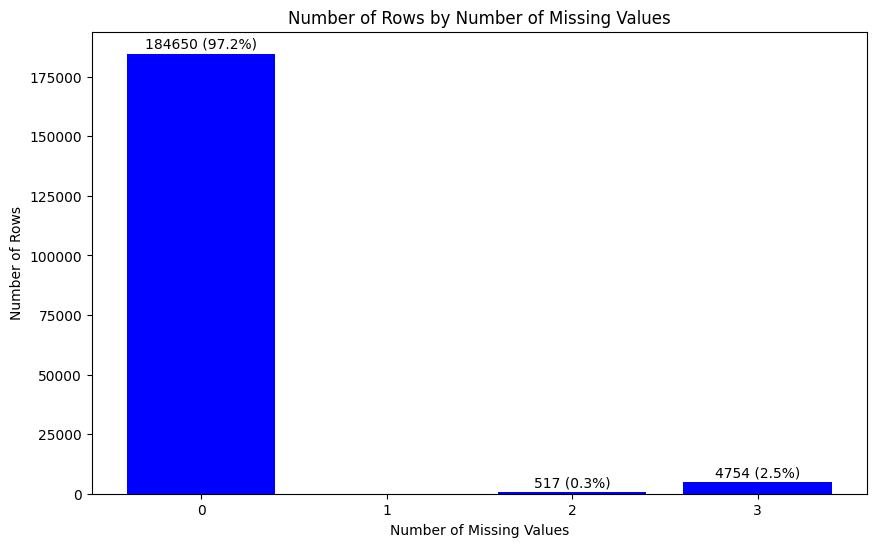

In [28]:
plt.figure(figsize=(10, 6))
bars = plt.bar(missing_value_counts.index, missing_value_counts.values, color="blue")
plt.xlabel("Number of Missing Values")
plt.ylabel("Number of Rows")
plt.title("Number of Rows by Number of Missing Values")
plt.xticks(np.arange(0, missing_value_counts.index.max() + 1 , step=1))

#adding annotations
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_rows) * 100
    plt.annotate(f'{height} ({percentage:.1f}%)',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0,2),
                 textcoords="offset points",
                 ha="center", va="bottom")
plt.show()

Vast majority of rows are not missing any values (97.2%). Great news!

Let's check what is missing among those rows that have missing values so we can decide what to do with them.

In [29]:
#filtering to rows with missing values
row_nan_identity = data_raw.isnull().any(axis=1)

rows_with_missing_values = data_raw[row_nan_identity]

rows_with_missing_values

,Disease,County,Year,Sex,Cases,Population,Rate,Lower_95__CI,Upper_95__CI
1182,Anaplasmosis,Lake,2021,Female,NaN,32069,SC,NaN,NaN
1183,Anaplasmosis,Lake,2021,Male,NaN,32105,SC,NaN,NaN
1230,Anaplasmosis,Lassen,2015,Female,NaN,11403,SC,NaN,NaN
1231,Anaplasmosis,Lassen,2015,Male,NaN,18797,SC,NaN,NaN
1491,Anaplasmosis,Mariposa,2014,Female,NaN,8935,SC,NaN,NaN
...,...,...,...,...,...,...,...,...,...
189880,Zika Virus Infection,Yolo,2016,Male,1.0,105685,-,NaN,NaN
189881,Zika Virus Infection,Yolo,2016,Total,4.0,213224,-,NaN,NaN
189900,Zika Virus Infection,Yuba,2016,Female,NaN,37246,-,NaN,NaN
189901,Zika Virus Infection,Yuba,2016,Male,NaN,38005,-,NaN,NaN


In [30]:
#show only columns with missing values
columns_with_missing = rows_with_missing_values.columns[rows_with_missing_values.isnull().any()]

rows_with_missing_values[columns_with_missing]

,Cases,Lower_95__CI,Upper_95__CI
1182,NaN,NaN,NaN
1183,NaN,NaN,NaN
1230,NaN,NaN,NaN
1231,NaN,NaN,NaN
1491,NaN,NaN,NaN
...,...,...,...
189880,1.0,NaN,NaN
189881,4.0,NaN,NaN
189900,NaN,NaN,NaN
189901,NaN,NaN,NaN


Since this is a relatively small proportion of the entire dataset, let's remove rows where Cases, Lower_95_CI and Upper_95_CI are missing. We can keep rows that just the confidence intervals are missing for now. 

In [31]:
data_filter = data_raw.dropna(subset=['Cases', 'Lower_95__CI', 'Upper_95__CI'], how="all")

In [32]:
#making sure it worked properly
row_nan_identity = data_filter.isnull().any(axis=1)

rows_with_missing_values = data_filter[row_nan_identity]

rows_with_missing_values

,Disease,County,Year,Sex,Cases,Population,Rate,Lower_95__CI,Upper_95__CI
31152,Chikungunya Virus Infection,Alameda,2016,Female,7.0,831872,-,NaN,NaN
31153,Chikungunya Virus Infection,Alameda,2016,Male,2.0,807094,-,NaN,NaN
31154,Chikungunya Virus Infection,Alameda,2016,Total,9.0,1647332,-,NaN,NaN
31173,Chikungunya Virus Infection,Alpine,2016,Female,0.0,564,-,NaN,NaN
31174,Chikungunya Virus Infection,Alpine,2016,Male,0.0,587,-,NaN,NaN
...,...,...,...,...,...,...,...,...,...
189860,Zika Virus Infection,Ventura,2016,Total,9.0,850227,-,NaN,NaN
189879,Zika Virus Infection,Yolo,2016,Female,3.0,110530,-,NaN,NaN
189880,Zika Virus Infection,Yolo,2016,Male,1.0,105685,-,NaN,NaN
189881,Zika Virus Infection,Yolo,2016,Total,4.0,213224,-,NaN,NaN


In [33]:
#change "-" in Rate to NaN
data_filter['Rate'].replace("-", np.nan, inplace=True)

data_filter

C:\Users\Alessia\AppData\Local\Temp\ipykernel_7004\2111518701.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_filter['Rate'].replace("-", np.nan, inplace=True)
C:\Users\Alessia\AppData\Local\Temp\ipykernel_7004\2111518701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filter['Rate'].replace("-", np.nan, inplace=True)


,Disease,County,Year,Sex,Cases,Population,Rate,Lower_95__CI,Upper_95__CI
0,Anaplasmosis,Alameda,2001,Female,0.0,746596,NaN,0.0,0.494
1,Anaplasmosis,Alameda,2001,Male,0.0,718968,NaN,0.0,0.513
2,Anaplasmosis,Alameda,2001,Total,0.0,1465564,NaN,0.0,0.252
3,Anaplasmosis,Alameda,2002,Female,0.0,747987,NaN,0.0,0.493
4,Anaplasmosis,Alameda,2002,Male,0.0,720481,NaN,0.0,0.512
...,...,...,...,...,...,...,...,...,...
189916,Zika Virus Infection,Yuba,2021,Male,0.0,39302,NaN,0.0,9.386
189917,Zika Virus Infection,Yuba,2021,Total,0.0,82211,NaN,0.0,4.487
189918,Zika Virus Infection,Yuba,2022,Female,0.0,39108,NaN,0.0,9.432
189919,Zika Virus Infection,Yuba,2022,Male,0.0,39558,NaN,0.0,9.325


Now let's check for duplicate rows and remove them

In [34]:
duplicate_rows = data_filter[data_filter.duplicated()]

duplicate_rows

,Disease,County,Year,Sex,Cases,Population,Rate,Lower_95__CI,Upper_95__CI


There are no duplicate rows!

Let's conduct initial checks for outliers

Z-Score Checks

In [35]:
#calculate z-scores for numeric columns
z_scores = np.abs(zscore(data_filter.select_dtypes(include=[np.number])))

In [36]:
#start with a threshold of 3
threshold=3

#identify outliers
outliers = (z_scores > threshold).any(axis=1)

#display outlier rows
outlier_rows = data_filter[outliers]

outlier_rows

#there are 3528 rows considered outliers based on the z-score, but I don't think this is too large of a concern, 
# since this data is wide-ranging, I'll proceed without worrying about outliers

,Disease,County,Year,Sex,Cases,Population,Rate,Lower_95__CI,Upper_95__CI
330,Anaplasmosis,California,2001,Female,0.0,17339700,NaN,0.000,0.021
331,Anaplasmosis,California,2001,Male,0.0,17173042,NaN,0.000,0.021
332,Anaplasmosis,California,2001,Total,0.0,34512742,NaN,0.000,0.011
333,Anaplasmosis,California,2002,Female,0.0,17554666,NaN,0.000,0.021
334,Anaplasmosis,California,2002,Male,0.0,17383624,NaN,0.000,0.021
...,...,...,...,...,...,...,...,...,...
188803,Zika Virus Infection,California,2021,Male,1.0,19938223,0.005*,0.000,0.028
188804,Zika Virus Infection,California,2021,Total,2.0,39239553,0.005*,0.001,0.018
188805,Zika Virus Infection,California,2022,Female,4.0,20104681,0.020*,0.005,0.051
188806,Zika Virus Infection,California,2022,Male,1.0,20041322,0.005*,0.000,0.028


One last item - let's remove the astericks from the Rate column and make it an integer data type

In [37]:
#remove "*" from all columns
data_filter = data_filter.replace({"\*": ""}, regex=True)

data_filter['Rate'] = pd.to_numeric(data_filter['Rate'], errors='coerce')

<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
C:\Users\Alessia\AppData\Local\Temp\ipykernel_7004\77568445.py:2: SyntaxWarning: invalid escape sequence '\*'
  data_filter = data_filter.replace({"\*": ""}, regex=True)


Final checks!

In [38]:
#renaming final dataset
data_clean = data_filter

data_clean.info()

data_clean.describe()

#now left with 185,167 obs, down from 189,921

<class 'pandas.core.frame.DataFrame'>
Index: 185167 entries, 0 to 189920
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Disease       185167 non-null  object 
 1   County        185167 non-null  object 
 2   Year          185167 non-null  int64  
 3   Sex           185167 non-null  object 
 4   Cases         185167 non-null  float64
 5   Population    185167 non-null  int64  
 6   Rate          38277 non-null   float64
 7   Lower_95__CI  184650 non-null  float64
 8   Upper_95__CI  184650 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 14.1+ MB


,Year,Cases,Population,Rate,Lower_95__CI,Upper_95__CI
count,185167.000000,185167.000000,1.851670e+05,38277.000000,184650.000000,184650.000000
mean,2011.779145,10.964783,8.745663e+05,5.117099,0.701369,22.161306
std,6.350012,148.355711,3.587696e+06,13.696045,5.625431,74.600165
min,2001.000000,0.000000,5.480000e+02,0.003000,0.000000,0.009000
25%,2006.000000,0.000000,3.110800e+04,0.256000,0.000000,1.197000
50%,2012.000000,0.000000,1.299380e+05,0.912000,0.000000,4.071000
75%,2017.000000,0.000000,4.331080e+05,4.934000,0.000000,14.394500
max,2022.000000,10016.000000,3.952957e+07,409.380000,391.260000,670.893000


The data now looks good and ready for visualization!

In [39]:
#exporting data to joblib
dump(data_clean, here('clean_data/data_clean.joblib'))

['c:\\Users\\Alessia\\Documents\\Personal Data Projects\\infectious disease surveillance\\infectious-disease-surveillance\\clean_data\\data_clean.joblib']